In [1]:
from anndata import AnnData
import scanpy.api as sc

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse
import os

import utils as u

/u/halle/rybakov/home_at/miniconda3/envs/work/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext memory_profiler
%matplotlib inline

In [4]:
A = np.random.rand(80000, 2000)
A[A<0.7]=0

size = int(A.nbytes/2**20)
print('~', size, 'MiB')

~ 1220 MiB


In [5]:
AD_dense = AnnData(A)

In [6]:
A = sp.sparse.csr_matrix(A)

size_sparse=int((A.data.nbytes + A.indptr.nbytes + A.indices.nbytes)/2**20)
print('~', size_sparse, 'MiB')

~ 549 MiB


In [7]:
AD_sparse = AnnData(A)

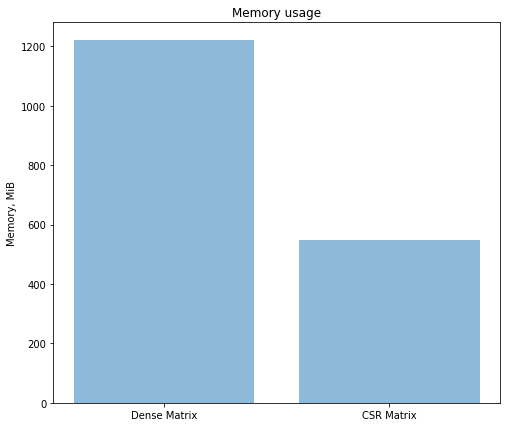

In [8]:
u.simple_bar(('Dense Matrix', 'CSR Matrix'), 'Memory, MiB', 'Memory usage', (size, size_sparse))

Use PCA to test as it uses chunks

In [12]:
timeit_dense = []
timeit_sparse = []

In [13]:
result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_dense, 50)
timeit_dense.append(result.average)

result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_dense, 50, chunked=True)
timeit_dense.append(result.average)

3.06 s ± 68.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
41.6 s ± 1.82 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [14]:
result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_sparse, 50)
timeit_sparse.append(result.average)

result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_sparse, 50, chunked=True)
timeit_sparse.append(result.average)

3.22 s ± 34.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
41.5 s ± 1.03 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


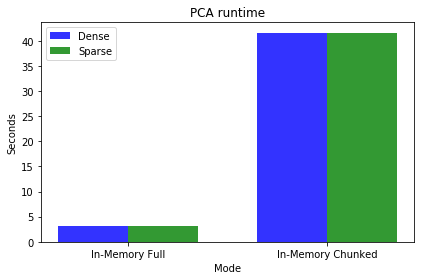

In [15]:
u.plot_groups(('In-Memory Full', 'In-Memory Chunked'), timeit_dense[:2], timeit_sparse[:2], 'Mode', 'Seconds', 'PCA runtime')

In [16]:
memit_dense = []
memit_sparse = []

In [17]:
result = %memit -o sc.pp.pca(AD_dense, 50)
memit_dense.append(max(result.mem_usage)-result.baseline)

result = %memit -o sc.pp.pca(AD_dense, 50, chunked=True)
memit_dense.append(max(result.mem_usage)-result.baseline)

peak memory: 3116.64 MiB, increment: 1221.49 MiB
peak memory: 2364.40 MiB, increment: 453.34 MiB


In [18]:
result = %memit -o sc.pp.pca(AD_sparse, 50)
memit_sparse.append(max(result.mem_usage)-result.baseline)

result = %memit -o sc.pp.pca(AD_sparse, 50, chunked=True)
memit_sparse.append(max(result.mem_usage)-result.baseline)

peak memory: 3763.75 MiB, increment: 1867.59 MiB
peak memory: 2397.74 MiB, increment: 528.88 MiB


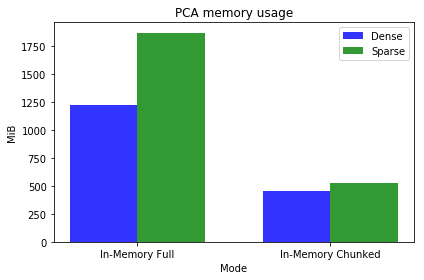

In [19]:
u.plot_groups(('In-Memory Full', 'In-Memory Chunked'), memit_dense, memit_sparse, 'Mode', 'MiB', 'PCA memory usage')

In [16]:
%mprun -f sc.pp.pca sc.pp.pca(AD_sparse, 50)
#Differs from memit for some reason

In [20]:
AD_dense_back = AnnData(AD_dense.X)
AD_dense_back.filename = './dense.h5ad'

AD_sparse_back = AnnData(AD_sparse.X)
AD_sparse_back.filename = './sparse.h5ad'

In [21]:
f_sz_dense = int(os.path.getsize('./dense.h5ad')/10**6)
f_sz_sparse = int(os.path.getsize('./sparse.h5ad')/10**6)

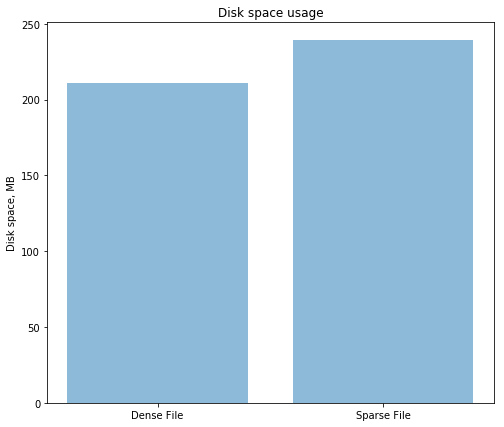

In [22]:
u.simple_bar(('Dense File', 'Sparse File'), 'Disk space, MB', 'Disk space usage', (f_sz_dense, f_sz_sparse))

In [23]:
result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_dense_back, 50)
timeit_dense.append(result.average)

timeit_sparse.append(0)

5.87 s ± 391 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [24]:
result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_dense_back, 50, chunked=True)
timeit_dense.append(result.average)

result = %timeit -o -r 3 -n 1 sc.pp.pca(AD_sparse_back, 50, chunked=True)
timeit_sparse.append(result.average)

45.8 s ± 283 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1min 38s ± 1.85 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


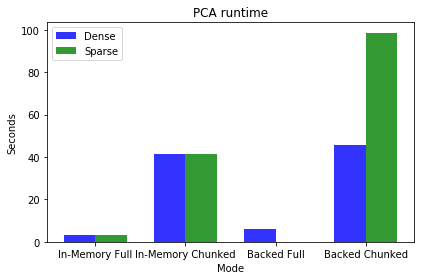

In [25]:
groups = ('In-Memory Full', 'In-Memory Chunked', 'Backed Full', 'Backed Chunked')
u.plot_groups(groups, timeit_dense, timeit_sparse, 'Mode', 'Seconds', 'PCA runtime')

In [26]:
AD_sparse_csc = AnnData(AD_sparse.X.tocsc())

The problem is in looping through rows

In [27]:
chunks_time = []

result = %timeit -o -r 3 -n 1 for _, _, _ in AD_dense.chunked_X(): pass
chunks_time.append(result.average)
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_sparse.chunked_X(): pass
chunks_time.append(result.average)
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_sparse_csc.chunked_X(): pass
chunks_time.append(result.average)
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_dense_back.chunked_X(): pass
chunks_time.append(result.average)
result = %timeit -o -r 3 -n 1 for _, _, _ in AD_sparse_back.chunked_X(): pass
chunks_time.append(result.average)

15.8 µs ± 5.5 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
174 ms ± 8.53 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
769 ms ± 7.37 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.91 s ± 18.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
28.8 s ± 380 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


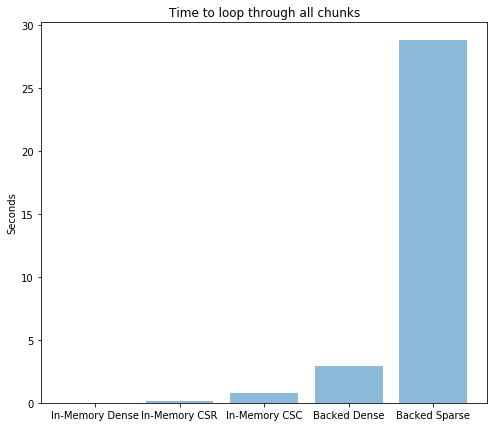

In [28]:
labels = ('In-Memory Dense', 'In-Memory CSR', 'In-Memory CSC', 'Backed Dense', 'Backed Sparse')
u.simple_bar(labels, 'Seconds', 'Time to loop through all chunks', chunks_time)

In [29]:
%memit sc.pp.pca(AD_dense_back, 50, chunked=True)
%memit sc.pp.pca(AD_sparse_back, 50, chunked=True)

peak memory: 2868.31 MiB, increment: 437.59 MiB
peak memory: 2907.12 MiB, increment: 520.58 MiB
